In [1]:
# does everybody really die in the summer?

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# importing data
shootings = pd.read_csv('data/boston_shootings.csv')
shootings.head()

,incident_num,shooting_date,district,shooting_type_v2,victim_gender,victim_race,victim_ethnicity_NIBRS,multi_victim
0,I152000196-00,2015-01-01 13:30:00+00,C11,Non-Fatal,Male,Black or African American,Not Hispanic or Latinx,f
1,I152000879-00,2015-01-04 01:58:00+00,E18,Non-Fatal,Male,Black or African American,Not Hispanic or Latinx,f
2,I152001014-00,2015-01-04 18:52:00+00,E5,Non-Fatal,Male,Black or African American,Not Hispanic or Latinx,f
3,I152002232-00,2015-01-08 22:45:00+00,B2,Non-Fatal,Male,Black or African American,Not Hispanic or Latinx,t
4,I152002233-00,2015-01-08 22:45:00+00,B2,Non-Fatal,Female,Black or African American,Not Hispanic or Latinx,t


In [3]:
# cleaning up shootings data

# converting the incident date to a datetime object
shootings['shooting_date'] = pd.to_datetime(shootings['shooting_date'])
shootings['shooting_date'] = shootings['shooting_date'].dt.date
shootings['shooting_date'] = pd.to_datetime(shootings['shooting_date'])

In [4]:
# adding an incident_count column, one for each occurence
shootings['incident_count'] = 1

# grouping by day and sum only the incident_count column
shootings_daily = shootings.groupby(['shooting_date']).sum().reset_index()

In [5]:
# read in weather data in 3 parts because of limitations on the NOAA API
weather1 = pd.read_csv('data/bos_weather_2015_2017.csv')
weather2 = pd.read_csv('data/bos_weather_2018_2020.csv')
weather3 = pd.read_csv('data/bos_weather_2021_2023.csv')

weather = pd.concat([weather1, weather2, weather3])

# isolating the columns we want
weather = weather[['DATE', 'AWND', 'PRCP', 'SNOW', 'TAVG']]
weather['DATE'] = pd.to_datetime(weather['DATE'])

In [6]:
# merging the shootings data with the weather data

# adding the shootings data to the weather data
# we want to merge the shootings into the weather data
# because we want an entry for every single day, even if there were no shootings
weather = weather.merge(shootings_daily, left_on='DATE', right_on='shooting_date', how='left')

# dropping the shooting_date column now that we've merged
weather = weather.drop(columns=['shooting_date'])

# rewriting weather data to a new variable we'll use for now
shootings_daily = weather

# replacing NaNs with 0s in the incident_count column
shootings_daily['incident_count'] = shootings_daily['incident_count'].fillna(0)

In [7]:
shootings_daily.head()
shootings_daily = shootings_daily[['DATE', 'AWND', 'PRCP', 'TAVG', 'incident_count']]

In [8]:
# let's create a new dataframe which tracks incidents per week
shootings_weekly = shootings_daily.resample('W-Mon', on='DATE').sum().reset_index().sort_values(by='DATE')

shootings_weekly.head()

,DATE,AWND,PRCP,TAVG,incident_count
0,2015-01-05,67.79,1.19,166,3.0
1,2015-01-12,83.67,0.23,145,5.0
2,2015-01-19,80.52,0.27,189,2.0
3,2015-01-26,78.29,0.81,208,11.0
4,2015-02-02,102.91,1.85,144,0.0


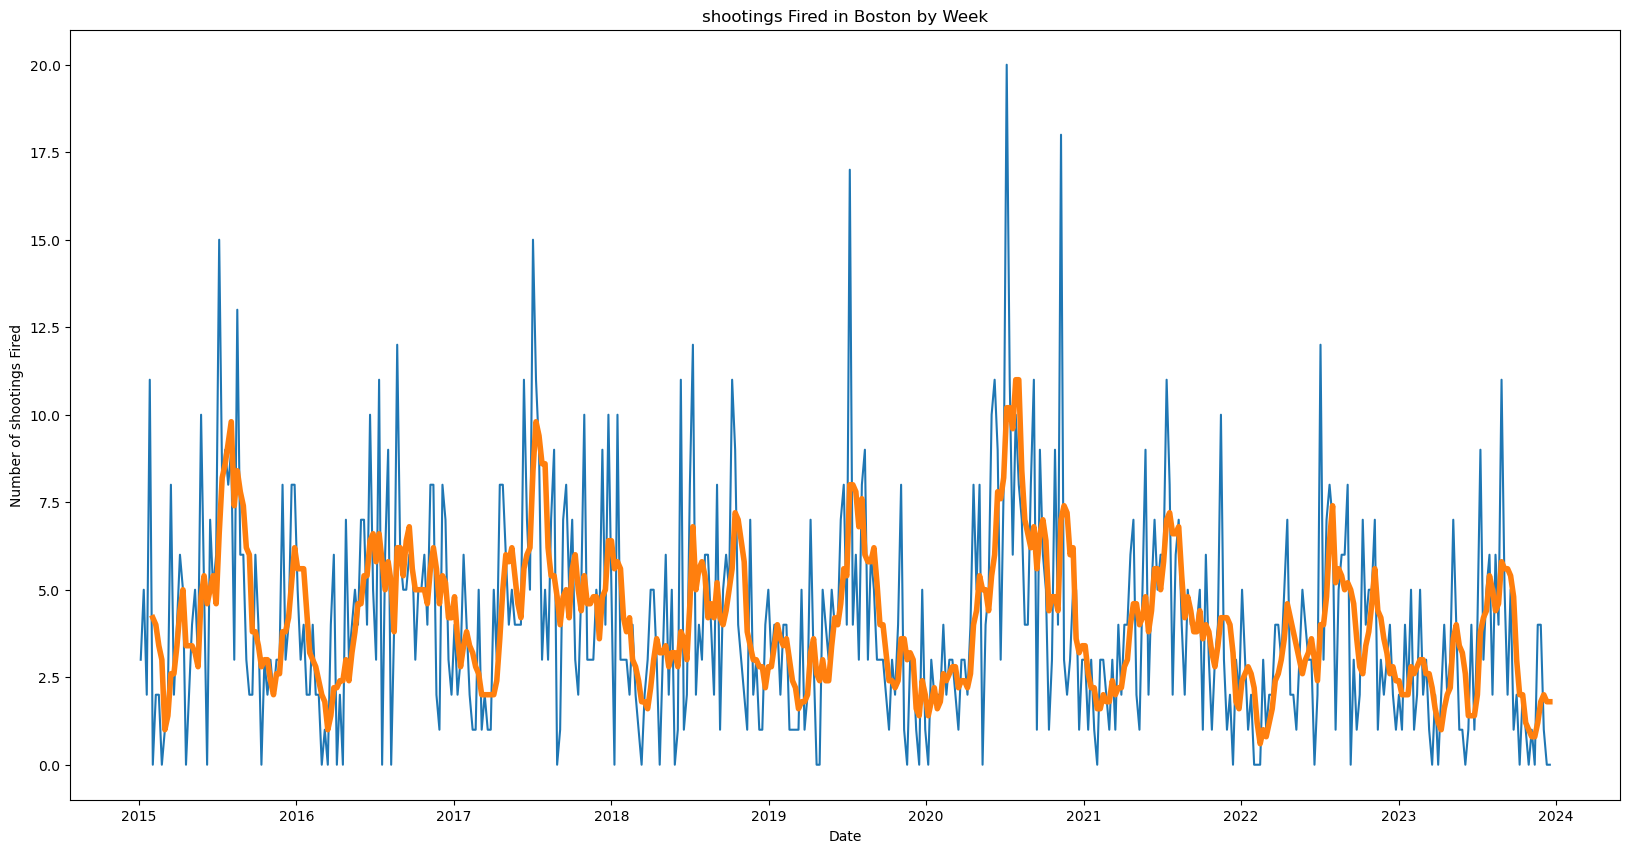

In [9]:
# let's add a moving average to the plot with a thicker line
plt.figure(figsize=(20,10))
plt.plot(shootings_weekly['DATE'], shootings_weekly['incident_count'])
plt.plot(shootings_weekly['DATE'], shootings_weekly['incident_count'].rolling(5).mean(), linewidth=4)
plt.title('shootings Fired in Boston by Week')
plt.xlabel('Date')
plt.ylabel('Number of shootings Fired')
plt.show()

In [10]:
import numpy as np
import datetime
import pandas as pd  # Assuming you're using pandas for DataFrame handling

def hours_of_daylight(date, latitude=42.36):
    """Compute the hours of daylight for the given date"""
    # Constants
    axial_tilt = 23.44
    days_in_year = 365.25

    # Day of the year
    day_of_year = date.timetuple().tm_yday

    # Declination angle calculation
    declination = axial_tilt * np.sin(np.radians((360 / days_in_year) * (day_of_year - 81)))

    # Hour angle calculation
    hour_angle = np.arccos(-np.tan(np.radians(latitude)) * np.tan(np.radians(declination)))

    # Daylight hours calculation
    daylight_hours = 2 * np.degrees(hour_angle) / 15

    return daylight_hours

# Replace 'shootings_weekly' with your DataFrame name
# Ensure the 'DATE' column in your DataFrame is of datetime type
# Example: shootings_weekly['DATE'] = pd.to_datetime(shootings_weekly['DATE'])

# Apply the function to each date in the DataFrame
shootings_weekly['daylight_hours'] = shootings_weekly['DATE'].apply(hours_of_daylight)

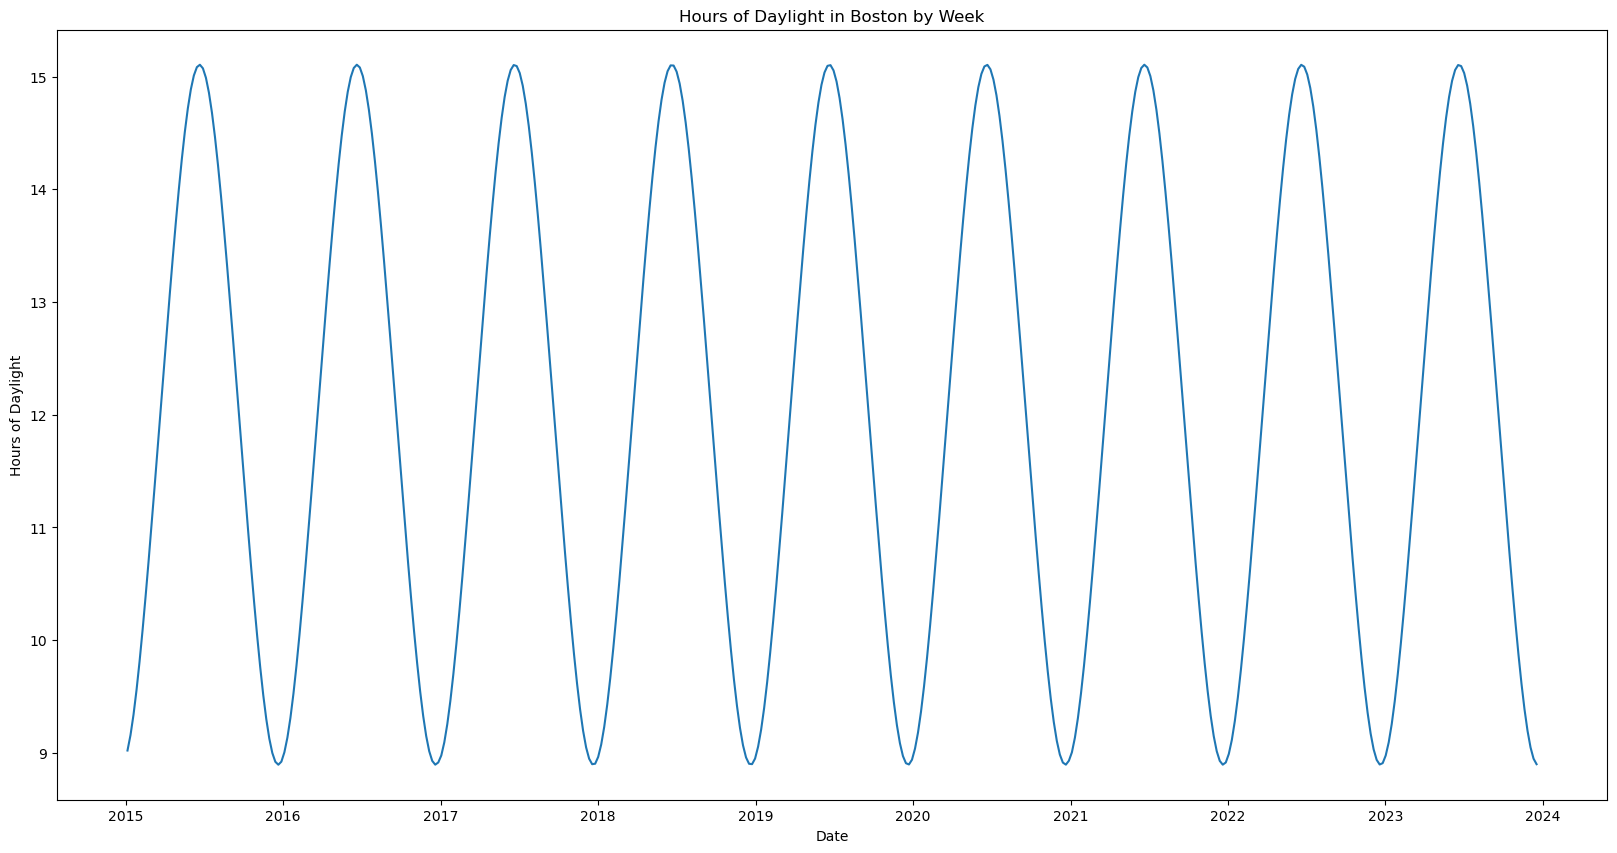

In [12]:
shootings_weekly.head(52)

# let's plot the hours of daylight
plt.figure(figsize=(20,10))
plt.plot(shootings_weekly['DATE'], shootings_weekly['daylight_hours'])
plt.title('Hours of Daylight in Boston by Week')
plt.xlabel('Date')
plt.ylabel('Hours of Daylight')
plt.show()


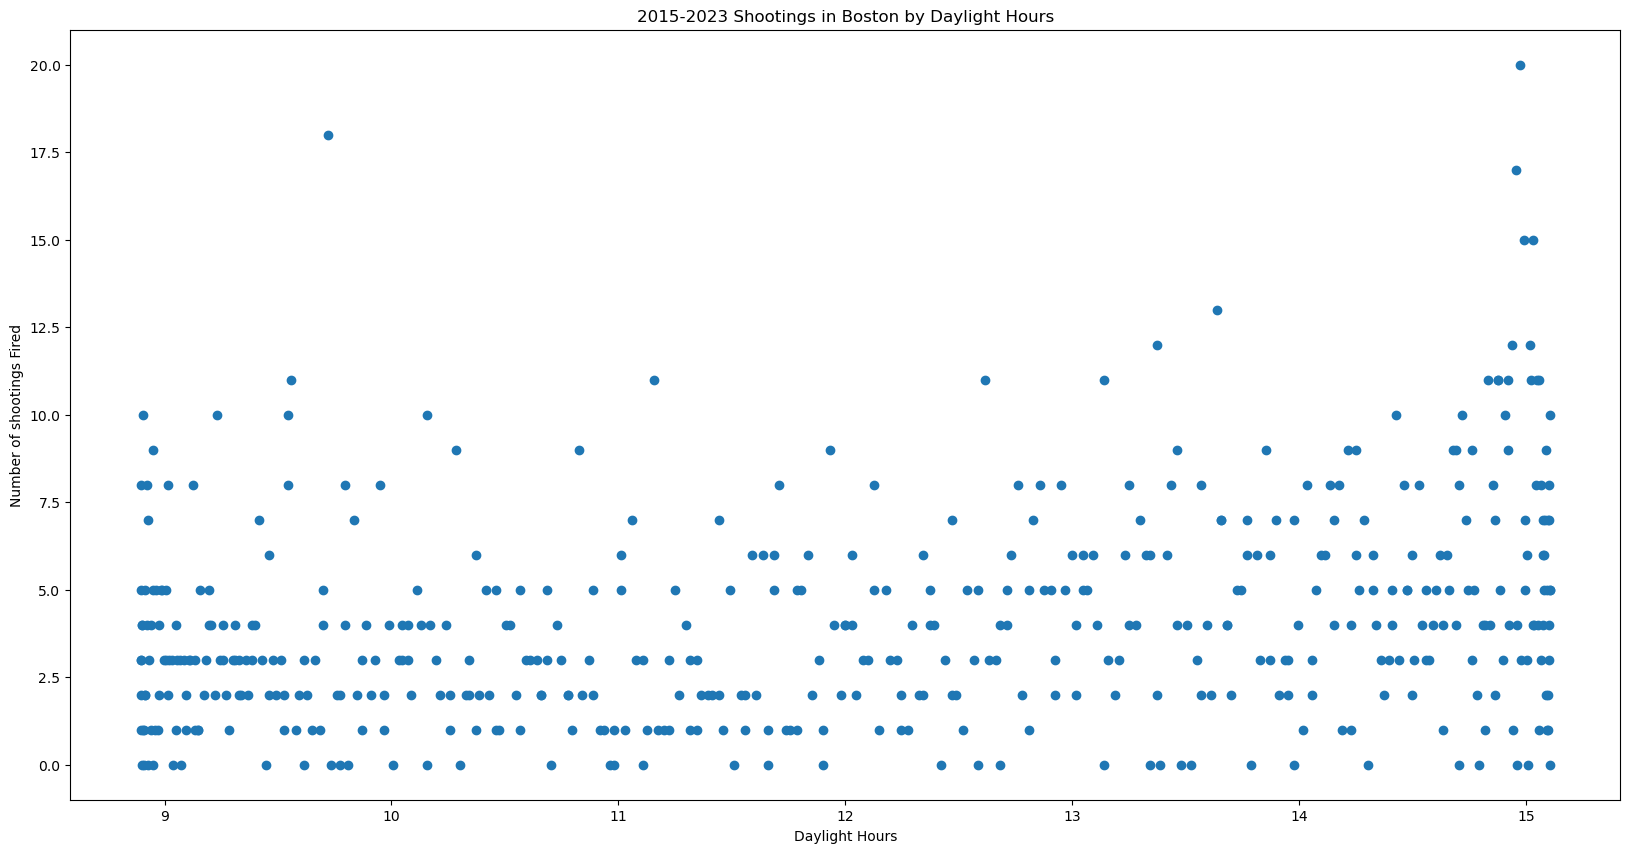

In [13]:
shootings_weekly = shootings_weekly[['DATE', 'incident_count', 'daylight_hours', 'TAVG', 'PRCP']]
shootings_weekly.head()

# let's plot the number of shootings fired against the number of daylight hours
plt.figure(figsize=(20,10))
plt.scatter(shootings_weekly['daylight_hours'], shootings_weekly['incident_count'])
plt.title('2015-2023 Shootings in Boston by Daylight Hours')
plt.xlabel('Daylight Hours')
plt.ylabel('Number of shootings Fired')
plt.show()


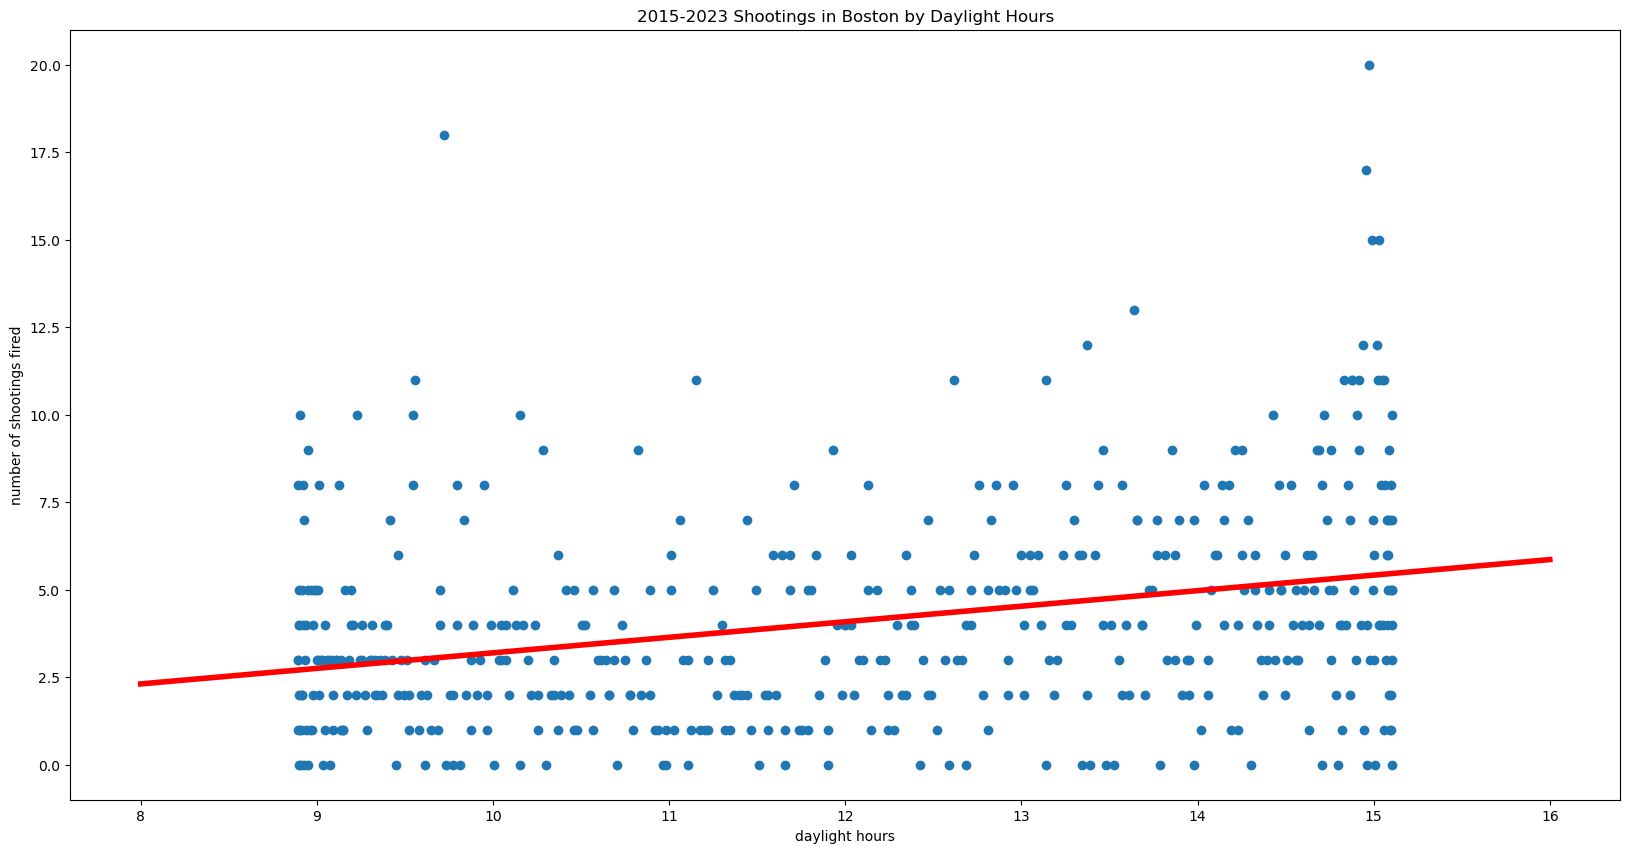

In [14]:
from sklearn.linear_model import LinearRegression

X = shootings_weekly['daylight_hours'].values.reshape(-1, 1)
y = shootings_weekly['incident_count'].values.reshape(-1, 1)
reg = LinearRegression(fit_intercept=True).fit(X, y)

shootings_weekly['daylight_trend'] = reg.predict(X)
shootings_weekly['daylight_corrected_total'] = shootings_weekly['incident_count'] - shootings_weekly['daylight_trend'] + shootings_weekly['daylight_trend'].mean()

xfit = np.linspace(8, 16)
yfit = reg.predict(xfit[:, None])
plt.figure(figsize=(20,10))
plt.scatter(shootings_weekly['daylight_hours'], shootings_weekly['incident_count'])
plt.plot(xfit, yfit, linewidth=4, color='red')
plt.title("2015-2023 Shootings in Boston by Daylight Hours")
plt.xlabel('daylight hours')
plt.ylabel('number of shootings fired');

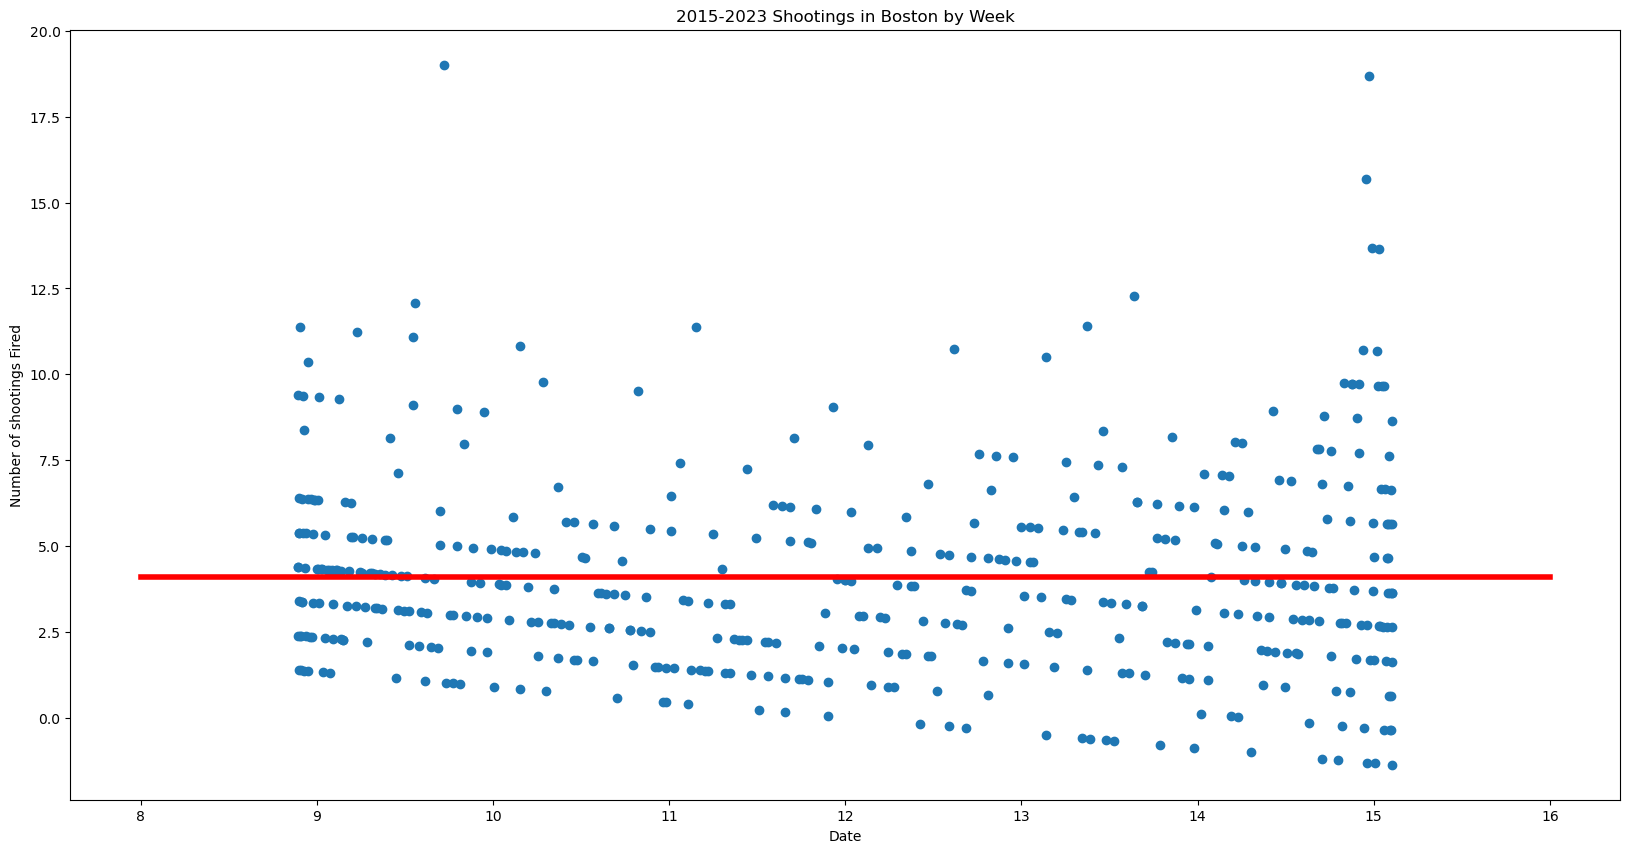

In [15]:
# let's detrend the data
trend = reg.predict(shootings_weekly[['daylight_hours']].to_numpy())
shootings_weekly['detrended'] = shootings_weekly['incident_count'] - trend.flatten() + trend.mean()

# let's plot the detrended data
plt.figure(figsize=(20,10))
plt.scatter(shootings_weekly['daylight_hours'], shootings_weekly['detrended'])
plt.plot(xfit, np.mean(trend) + 0 * yfit, linewidth=4, color='red')
plt.title('2015-2023 Shootings in Boston by Week')
plt.xlabel('Date')
plt.ylabel('Number of shootings Fired')
plt.show()


In [16]:
# read in weather data in 3 parts because of limitations on the NOAA API
weather1 = pd.read_csv('data/bos_weather_2015_2017.csv')
weather2 = pd.read_csv('data/bos_weather_2018_2020.csv')
weather3 = pd.read_csv('data/bos_weather_2021_2023.csv')

weather = pd.concat([weather1, weather2, weather3])

# isolating the columns we want
weather = weather[['DATE', 'AWND', 'PRCP', 'SNOW', 'TAVG']]
weather['DATE'] = pd.to_datetime(weather['DATE'])

# converting weather to a weekly dataframe
weather_weekly = weather.resample('W-Mon', on='DATE').mean().reset_index().sort_values(by='DATE')
weather_weekly = weather_weekly[['DATE', 'PRCP', 'TAVG']]

In [17]:
weather_weekly.head()

,DATE,PRCP,TAVG
0,2015-01-05,0.238000,33.200000
1,2015-01-12,0.032857,20.714286
2,2015-01-19,0.038571,27.000000
3,2015-01-26,0.115714,29.714286
4,2015-02-02,0.264286,20.571429


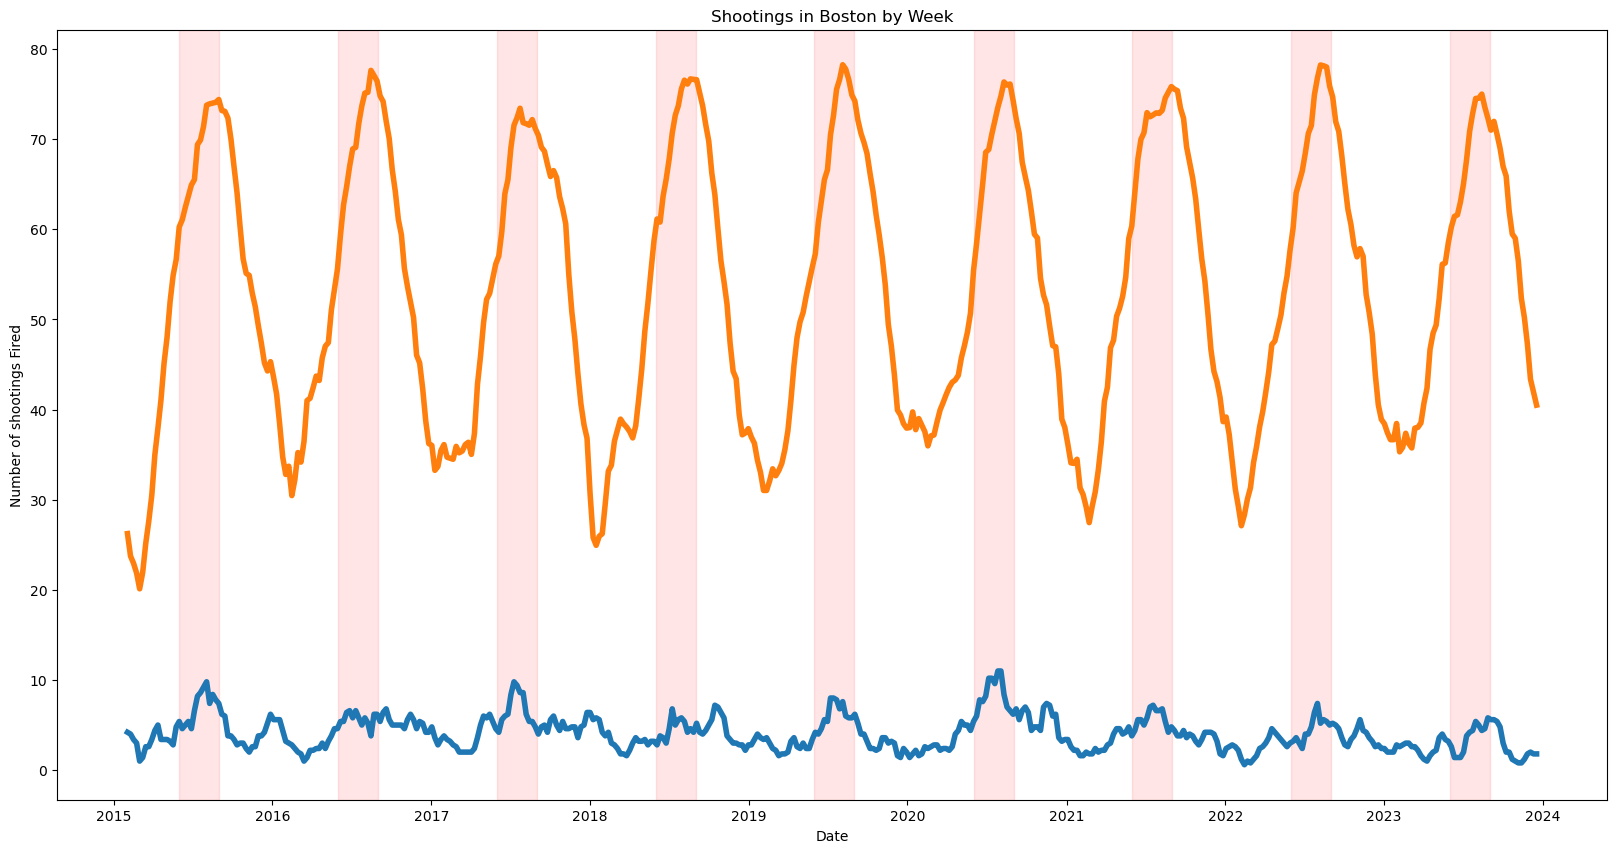

In [18]:
# plotting shootings fired vs average temperature
plt.figure(figsize=(20,10))
plt.plot(shootings_weekly['DATE'], shootings_weekly['incident_count'].rolling(5).mean(), linewidth=4)
plt.plot(weather_weekly['DATE'], weather_weekly['TAVG'].rolling(5).mean(), linewidth=4)
plt.title('Shootings in Boston by Week')
plt.xlabel('Date')
plt.ylabel('Number of shootings Fired')

# plotting the summer months in as vertical red bars
plt.axvspan('2015-06-01', '2015-09-01', color='red', alpha=0.1)
plt.axvspan('2016-06-01', '2016-09-01', color='red', alpha=0.1)
plt.axvspan('2017-06-01', '2017-09-01', color='red', alpha=0.1)
plt.axvspan('2018-06-01', '2018-09-01', color='red', alpha=0.1)
plt.axvspan('2019-06-01', '2019-09-01', color='red', alpha=0.1)
plt.axvspan('2020-06-01', '2020-09-01', color='red', alpha=0.1)
plt.axvspan('2021-06-01', '2021-09-01', color='red', alpha=0.1)
plt.axvspan('2022-06-01', '2022-09-01', color='red', alpha=0.1)
plt.axvspan('2023-06-01', '2023-09-01', color='red', alpha=0.1)

plt.show()

### Summer Nights Appears To Be The Worst Time

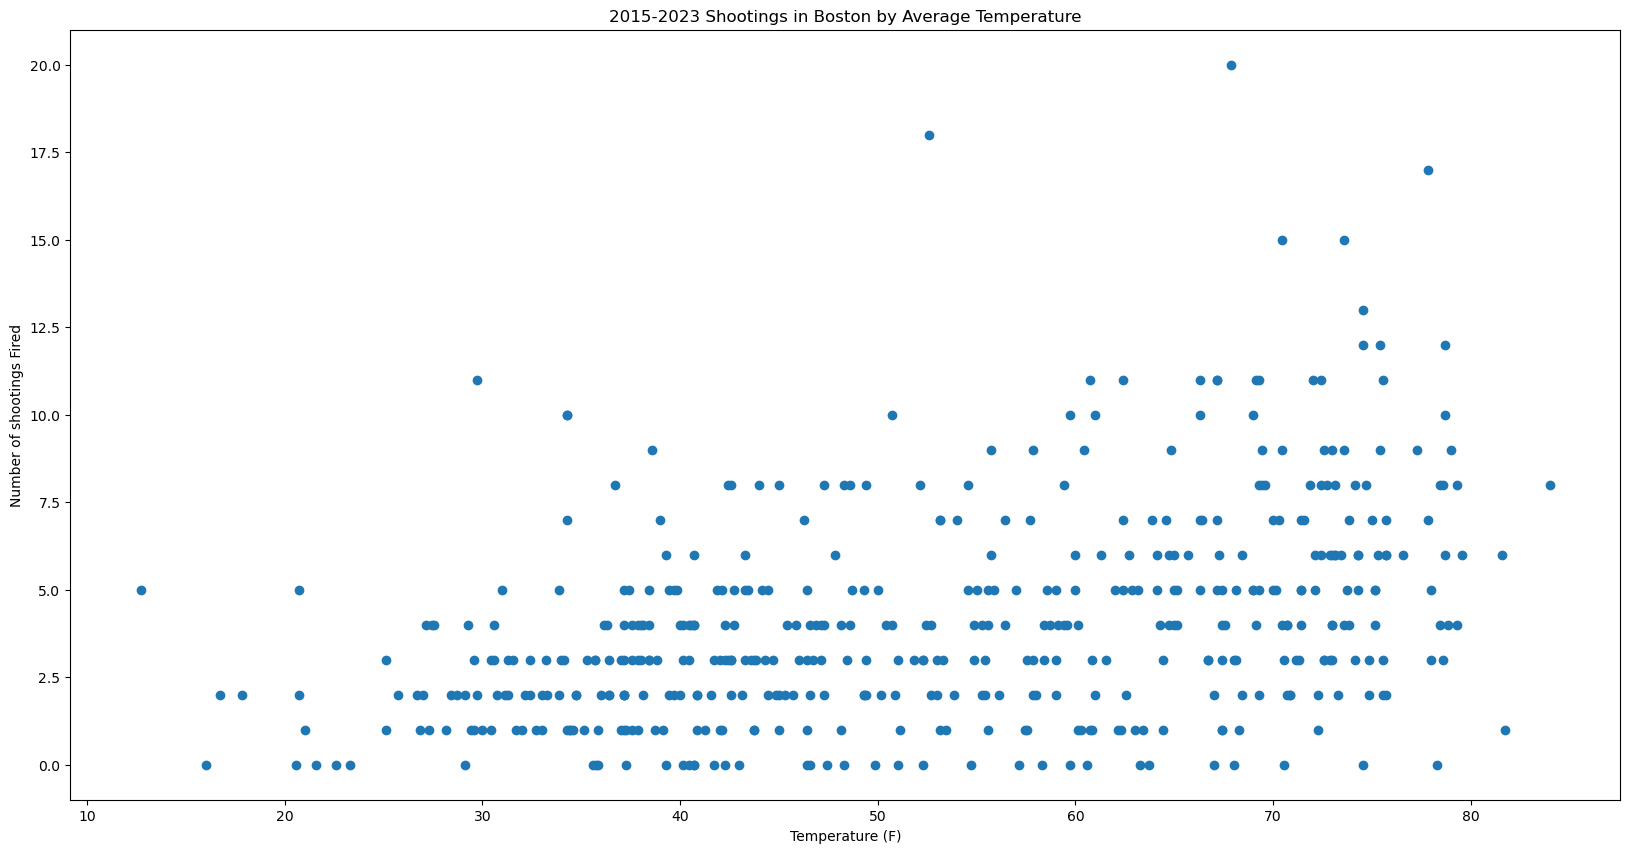

In [19]:
# let's plot the number of shootings fired against the number of daylight hours
plt.figure(figsize=(20,10))
plt.scatter(weather_weekly['TAVG'], shootings_weekly['incident_count'])
plt.title('2015-2023 Shootings in Boston by Average Temperature')
plt.xlabel('Temperature (F)')
plt.ylabel('Number of shootings Fired')
plt.show()

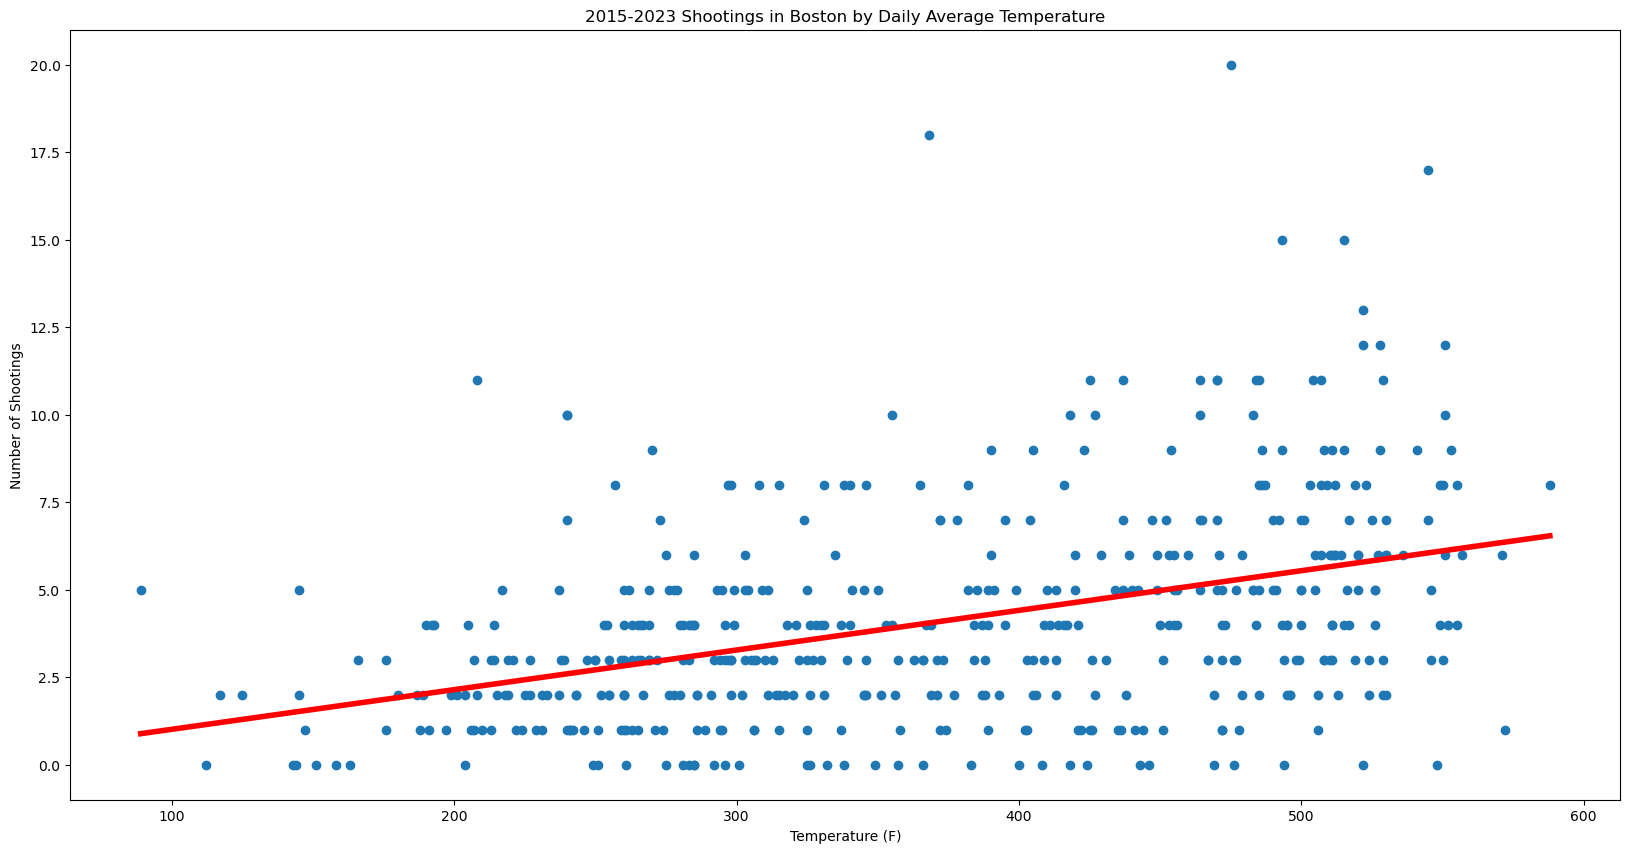

In [20]:
X = shootings_weekly['TAVG'].values.reshape(-1, 1)
y = shootings_weekly['incident_count'].values.reshape(-1, 1)
reg = LinearRegression(fit_intercept=True).fit(X, y)

shootings_weekly['TAVG_trend'] = reg.predict(X)
shootings_weekly['TAVG_corrected_total'] = shootings_weekly['incident_count'] - shootings_weekly['TAVG_trend'] + shootings_weekly['TAVG_trend'].mean()

xfit = np.linspace(shootings_weekly['TAVG'].min(), shootings_weekly['TAVG'].max())
yfit = reg.predict(xfit[:, None])
plt.figure(figsize=(20,10))
plt.scatter(shootings_weekly['TAVG'], shootings_weekly['incident_count'])
plt.plot(xfit, yfit, linewidth=4, color='red')
plt.title("2015-2023 Shootings in Boston by Daily Average Temperature")
plt.xlabel('Temperature (F)')
plt.ylabel('Number of Shootings')
plt.show()


In [21]:
shootings_weekly.head()

,DATE,incident_count,daylight_hours,TAVG,PRCP,daylight_trend,daylight_corrected_total,detrended,TAVG_trend,TAVG_corrected_total
0,2015-01-05,3.0,9.020912,166,1.19,2.762069,4.327675,4.327675,1.759408,5.330336
1,2015-01-12,5.0,9.157937,145,0.23,2.822920,6.266824,6.266824,1.521482,7.568262
2,2015-01-19,2.0,9.338895,189,0.27,2.903281,3.186462,3.186462,2.019994,4.069750
3,2015-01-26,11.0,9.558203,208,0.81,3.000673,12.089071,12.089071,2.235260,12.854483
4,2015-02-02,0.0,9.809899,144,1.85,3.112449,0.977295,0.977295,1.510152,2.579592


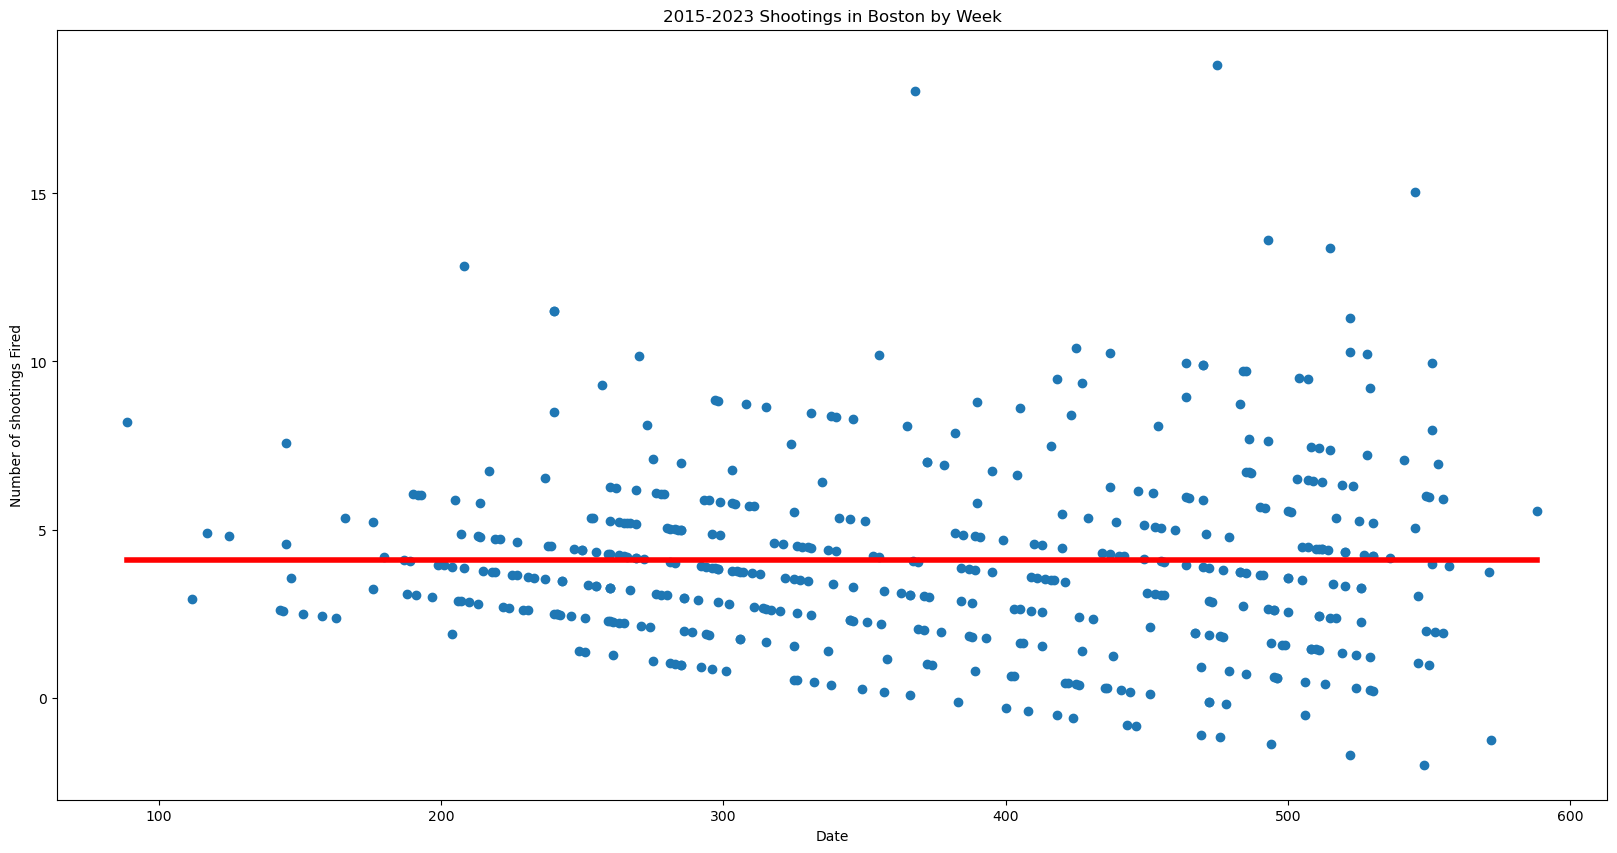

In [22]:
# let's detrend the data
trend = reg.predict(shootings_weekly['TAVG'].values.reshape(-1, 1))
shootings_weekly['detrended'] = shootings_weekly['incident_count'] - trend.flatten() + trend.mean()

# let's plot the detrended data
plt.figure(figsize=(20,10))
plt.scatter(shootings_weekly['TAVG'], shootings_weekly['detrended'])
plt.plot(xfit, np.mean(trend) + 0 * yfit, linewidth=4, color='red')
plt.title('2015-2023 Shootings in Boston by Week')
plt.xlabel('Date')
plt.ylabel('Number of shootings Fired')
plt.show()

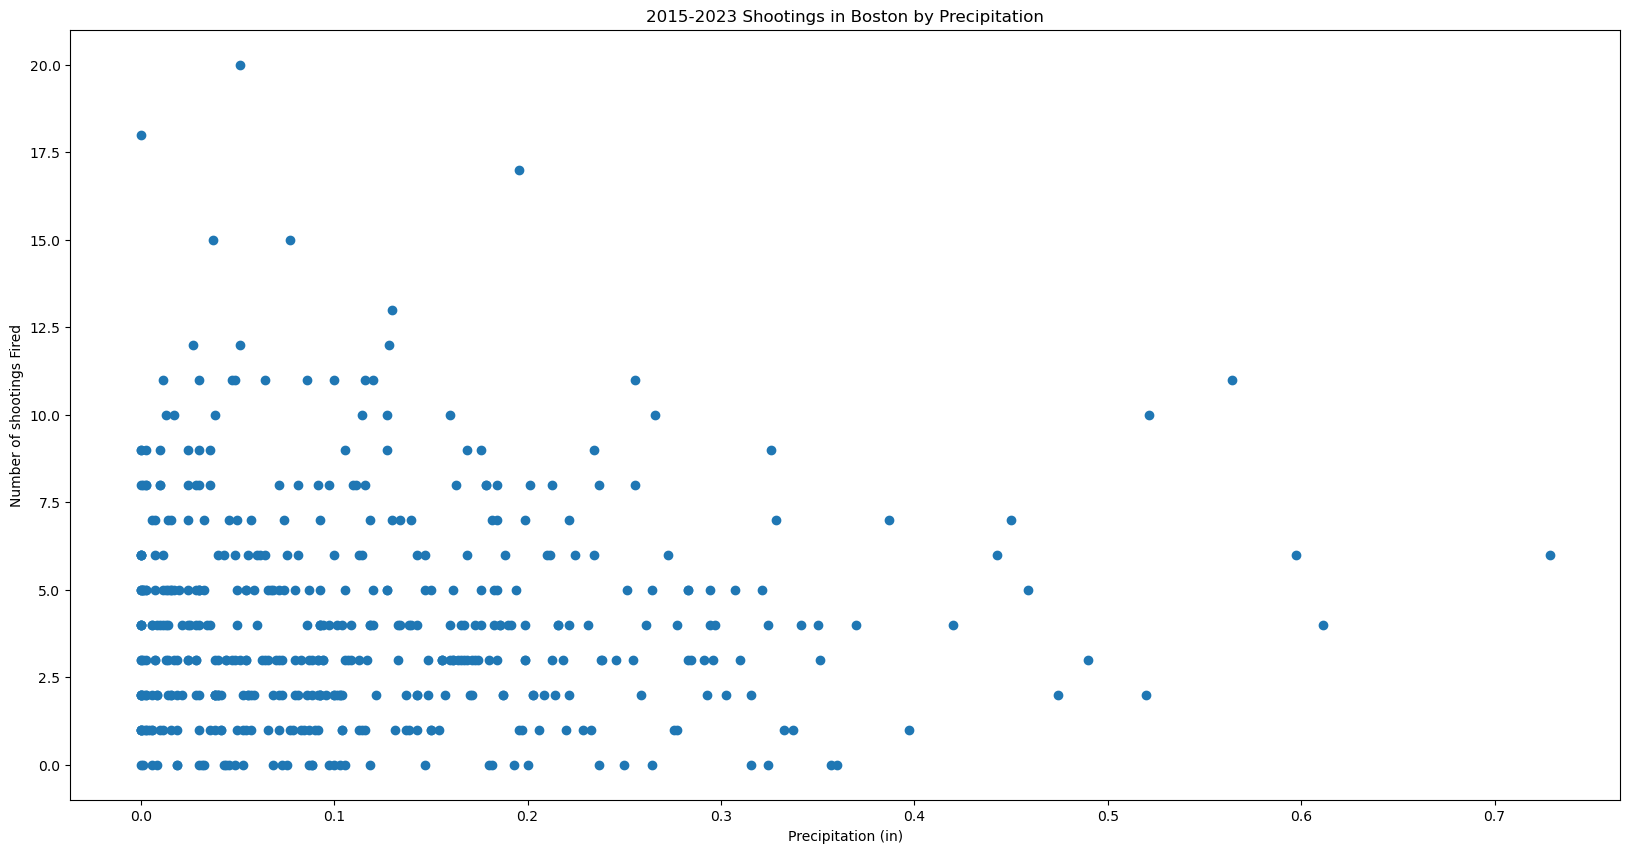

In [23]:
# let's do the same but for precipitation
plt.figure(figsize=(20,10))
plt.scatter(weather_weekly['PRCP'], shootings_weekly['incident_count'])
plt.title('2015-2023 Shootings in Boston by Precipitation')
plt.xlabel('Precipitation (in)')
plt.ylabel('Number of shootings Fired')
plt.show()

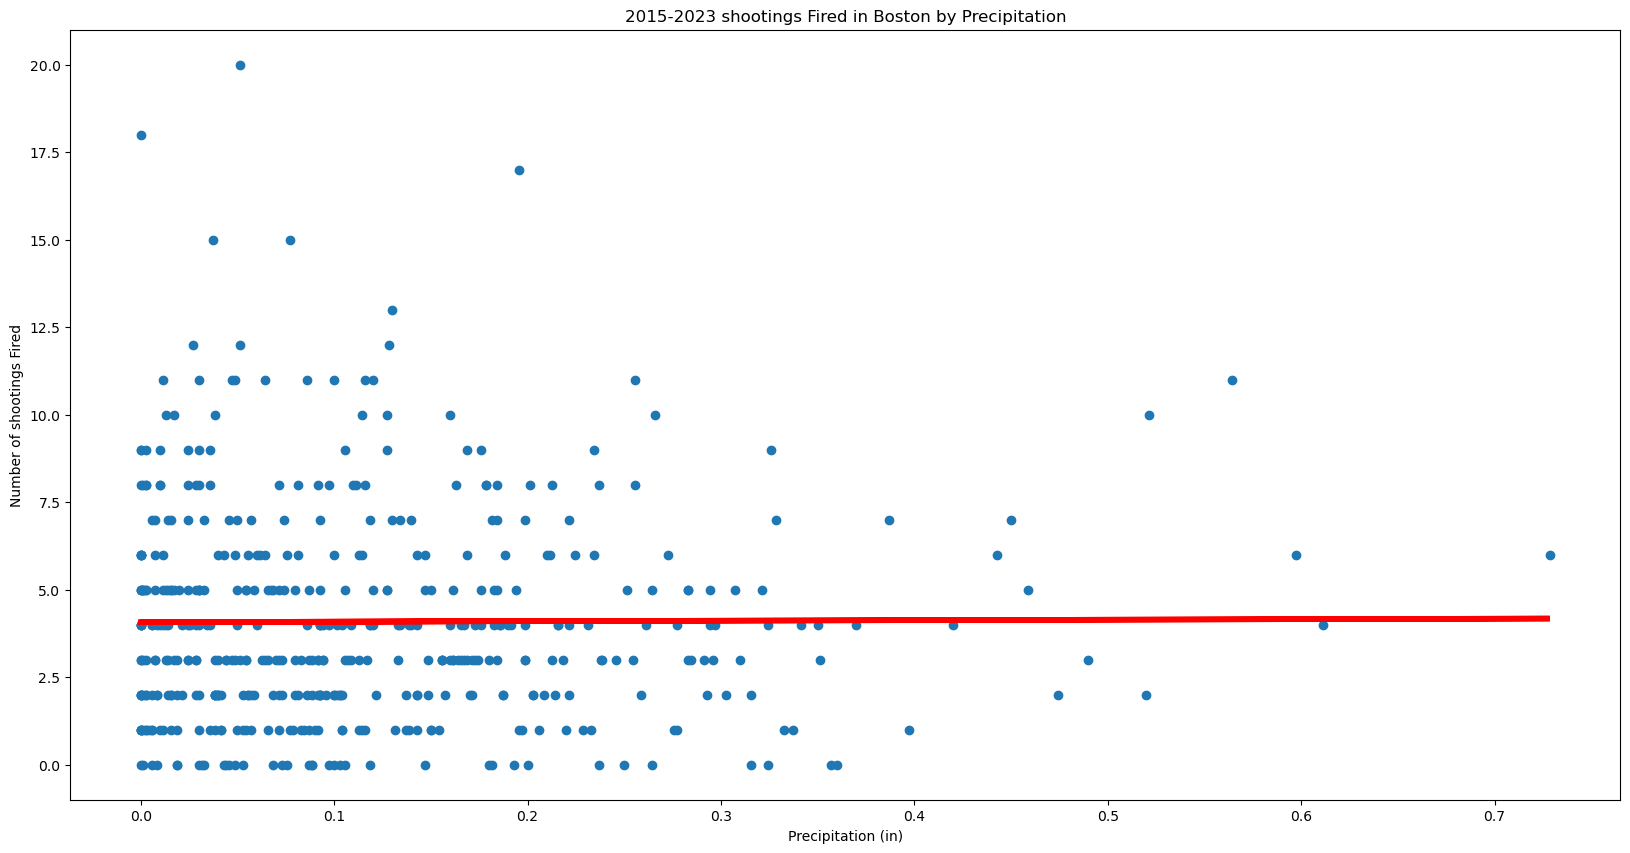

Coefficients: 
 [[0.14214701]]
Intercept: 
 [4.07310397]
R-squared: 
 2.6980461244940912e-05


In [24]:
# now let's try to fit a line to this data with linear regression

# we need to reshape the data for sklearn
precip = weather_weekly['PRCP'].values.reshape(-1, 1)
incident_count = shootings_weekly['incident_count'].values.reshape(-1, 1)

# creating the model
model = LinearRegression()
model.fit(precip, incident_count)

# let's plot the data and the line of best fit
plt.figure(figsize=(20,10))
plt.scatter(precip, incident_count)
plt.plot(precip, model.predict(precip), color='red', linewidth=4)
plt.title('2015-2023 shootings Fired in Boston by Precipitation')
plt.xlabel('Precipitation (in)')
plt.ylabel('Number of shootings Fired')
plt.show()

# let's print the coefficients
print('Coefficients: \n', model.coef_)
print('Intercept: \n', model.intercept_)
print('R-squared: \n', model.score(precip, incident_count))

- Currently, daylight hours isn't a driving force in shootings fired, but temperature and daylight hours seems to be

In [25]:
# plt.scatter(shootings_daily['daylight_hours'], shootings_daily['incident_count'], alpha=0.1)
# plt.xlabel('hours of daylight')
# plt.ylabel('incident count')

# # very interesting. on first glance, the hours of daylight doesn't seem to
# # have much of a correlation with the incident count
# # this sort of makes sense, as you may imagine that illegal activity might occur
# # more often at night, when there is less daylight